In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install nltk
import nltk
!pip install -q wordcloud
import wordcloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import MDS


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
data=pd.read_csv("/content/drive/MyDrive/webscrape_MAMIA.csv")

In [10]:
def plot_most_frequent_words(dataframes, titles):
    
    # The count inidcates where in the subplot to go
    count = 0
    fig   = plt.figure(figsize   = (24,20),
                       facecolor = "white")
    
    # Enumerating allows for the list of titles to be referenced
    for d, dataframe in enumerate(dataframes):
        
        # Updating the location
        count += 1
        ax    = fig.add_subplot(2, 2, count)
        
        # Creating the graph
        sns.barplot(x       = 0,
                    y       = dataframe.index,
                    data    = dataframe,
                    palette = "deep")
        
        # Setting the graph parameters
        plt.title(f"Most Common Words From {titles[d]}", size = 20)
        plt.xlabel("Number Of Occurences", size = 18)
        plt.ylabel("Word", size = 18)
        plt.xticks(size = 16)
        plt.yticks(size = 17)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


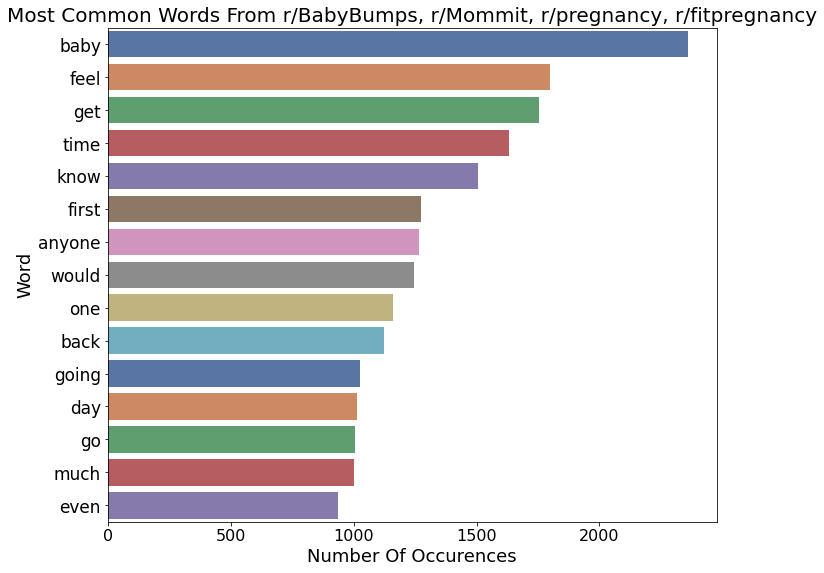

In [17]:
# Instantiating the count vectorizer

vectorizer = CountVectorizer()

# Masking the vectorizer with English stop words
nltk.download('stopwords')

new_stopwords = ["like", "just", "im", "dont",
                 "ive", "really", "want","also",'pregnancy','pregnant','week','weeks']

stop_words= stopwords.words('english')
stop_words.extend(new_stopwords)
cvec_data= CountVectorizer(stop_words = stop_words)
vec= cvec_data.fit_transform(data["text"])

vec= pd.DataFrame(vec.toarray(),columns = cvec_data.get_feature_names())
vec=vec.sum()
vec_top= pd.DataFrame(vec.sort_values(ascending = False).head(15))

# Plotting the most common words
plot_most_frequent_words(dataframes=[vec_top],titles=['r/BabyBumps, r/Mommit, r/pregnancy, r/fitpregnancy'])

In [19]:

# Build tf-idf vectorizer and cosine similarity matrix
def build_vectorizer(sentences, vocab=None, min_df=0.0, max_df=1.0, ngram_range=(1,1)):   # for a 2-gram use: ngram_range=(1,2)
    '''
    Build the tf-idf vectorizer: 
    1. Build the count_vectorizer from the input sentences.
    2. Transform count_vectorizer to bag-of-words.
    3. Fit the transform to the bag-of-words.
    
    Note:
    Alternatively we can do this directly with 'TfidfVectorizer' instead of using 'CountVectorizer' followed by 'TfidfTransformer'
    
    Return:
    cvec, feature_names, df_bag_of_words, tfidf, df_weights, cos_sim, samp_dist
    '''
    
    # Build count vectorizer
    count_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, vocabulary=vocab, ngram_range=(1,1),stop_words = stop_words)  # stop_words='english, max_features=N_FEATURES 
    cvec = count_vectorizer.fit(data['text'])

    # Get feature names
    feature_names = cvec.get_feature_names()

    # Get bag-of-words and analyze
    bag_of_words = cvec.transform(data['text'])
    df_bag_of_words = pd.DataFrame(bag_of_words.todense(), columns=feature_names)
    
    # Transform bag_of_words into tf-idf matrix
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(bag_of_words)

    # Find most popular words and highest weights
    word_cnts = np.asarray(bag_of_words.sum(axis=0)).ravel().tolist()  # for each word in column, sum all row counts
    df_cnts = pd.DataFrame({'word': feature_names, 'count': word_cnts})
    df_cnts = df_cnts.sort_values('count', ascending=False)

    # Build word weights as a list and sort them
    weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
    df_weights = pd.DataFrame({'word': feature_names, 'weight': weights})
    df_weights = df_weights.sort_values('weight', ascending=False)

    df_weights = df_weights.merge(df_cnts, on='word', how='left')
    df_weights = df_weights[['word', 'count', 'weight']]

    # Cosine similarity of sentences
    cos_sim = cosine_similarity(tfidf, tfidf)

    # Distance matrix of sentences
    samp_dist = 1 - cos_sim

    return cvec, feature_names, df_bag_of_words, tfidf, df_weights, cos_sim, samp_dist
  
# Build
cvec, feature_names, df_bag_of_words, tfidf, df_weights, cos_sim, samp_dist = build_vectorizer(data["text"])

df_tfidf = pd.DataFrame(tfidf.todense(), columns=feature_names)


                 word  count    weight
0                baby   2359  0.027406
1                feel   1798  0.021896
2                 get   1754  0.019695
3                time   1634  0.019141
4              anyone   1267  0.019050
...               ...    ...       ...
19360   rjunepreggers      1  0.000007
19361  rmarchpreggers      1  0.000007
19362    newredditcom      1  0.000007
19363          apollo      1  0.000007
19364             web      1  0.000007

[19365 rows x 3 columns]


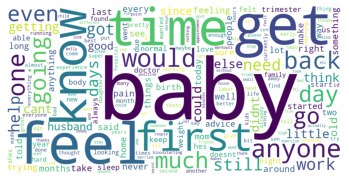

In [20]:
print(df_weights)
s_word_freq = pd.Series(df_weights['count'])
s_word_freq.index = df_weights['word']
di_word_freq = s_word_freq.to_dict()

cloud = wordcloud.WordCloud(width=1200, height=600, background_color="white").generate_from_frequencies(di_word_freq)
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [24]:
# Dimensionality reduction using PCA, reduce the tfidf matrix to just 2 features
X = tfidf.todense()
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

print(X_pca)

[[-0.06893083  0.03973322]
 [ 0.19714194 -0.09014666]
 [-0.08656838  0.07765013]
 ...
 [-0.12840483 -0.00573225]
 [-0.02454978  0.05474515]
 [ 0.03048094  0.10234208]]


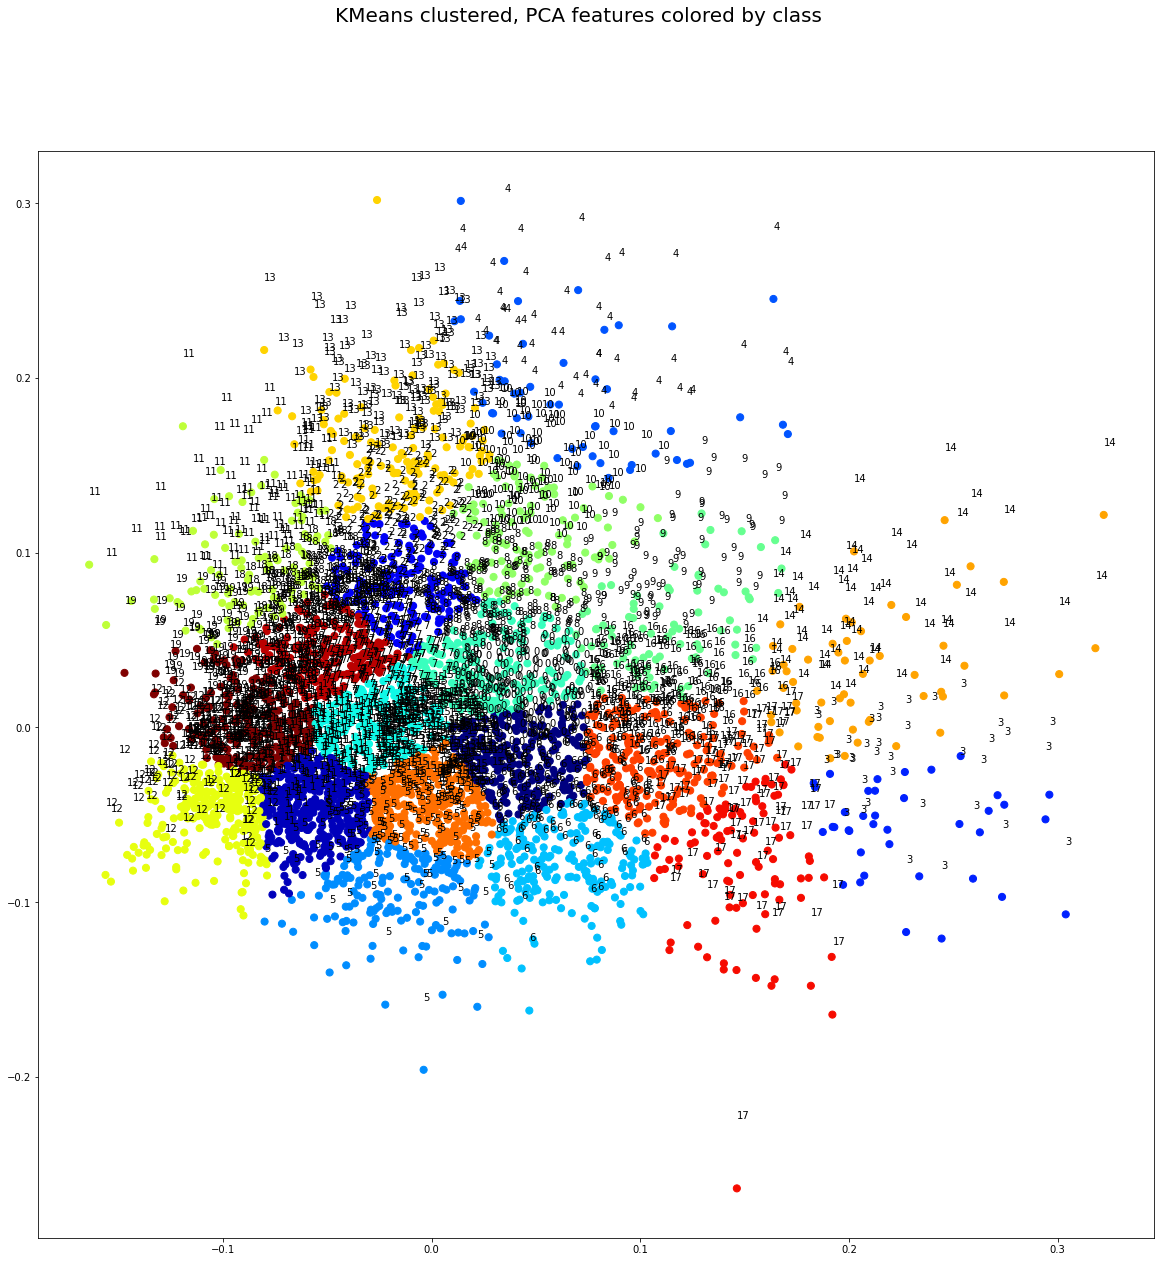

In [25]:
km_model = KMeans(n_clusters=20, max_iter=10, n_init=2, random_state=0)

# K-means (from number of features in input matrix to n_clusters)
prediction=km_model.fit(X_pca)
df_centers = pd.DataFrame(km_model.cluster_centers_)

plt.figure(figsize=(20,20))
plt.suptitle('KMeans clustered, PCA features colored by class', fontsize=20)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km_model.labels_, s=50, cmap='jet')
#plt.scatter(df_centers['x'], df_centers['y'], c='grey', s=500, alpha=0.2);

dy = 0.04
for i, txt in enumerate(km_model.labels_):
    plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1] + dy))

In [26]:
def get_top_features_cluster(tf_idf_array,feature_names, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array.iloc[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = feature_names
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

dfs = get_top_features_cluster(df_tfidf ,feature_names, km_model.labels_, 15)

In [39]:
id_ex= np.where(km_model.labels_==13)
x_means= np.mean(df_tfidf.iloc[id_ex], axis = 0)


In [41]:
x_means

aa                     0.000000
aaaaaaaaaahhhhhhhhh    0.000000
aaaaand                0.000000
aaaand                 0.001728
aampe                  0.000000
                         ...   
zoo                    0.000000
zoom                   0.000000
zoomies                0.000000
zumba                  0.000926
zyrtec                 0.000000
Length: 19365, dtype: float64

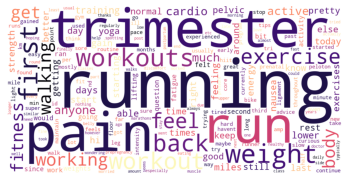

In [44]:
cloud = wordcloud.WordCloud(width=1200, height=600, background_color="white",colormap='magma').generate_from_frequencies(x_means)
plt.imshow(cloud)
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Exercise topic')

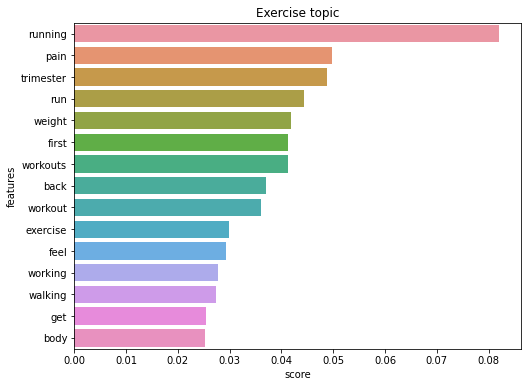

In [47]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[13][:15]).set_title('Exercise topic')

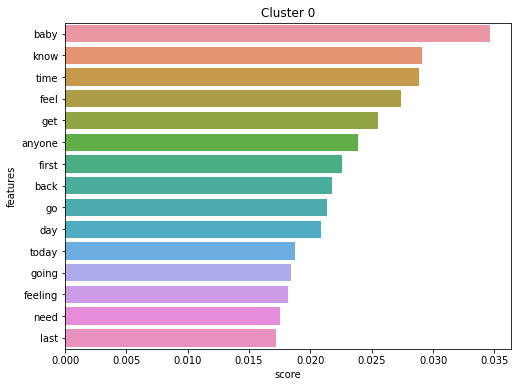

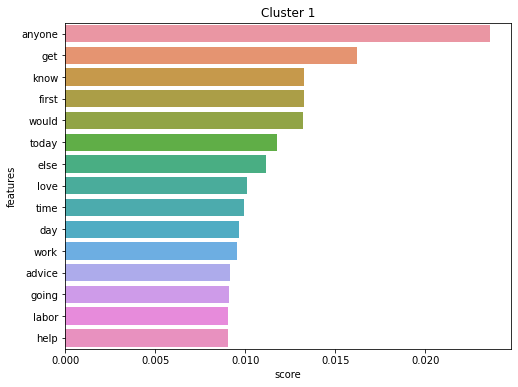

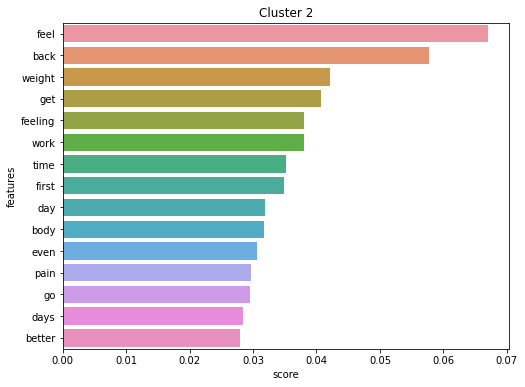

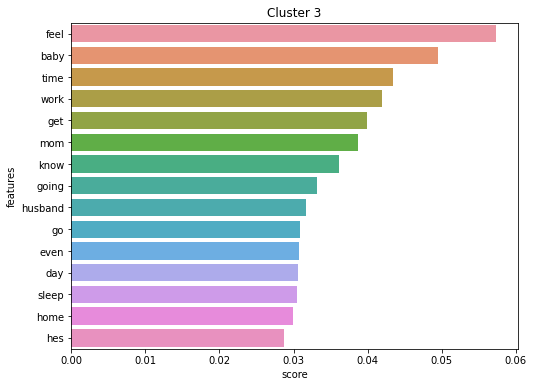

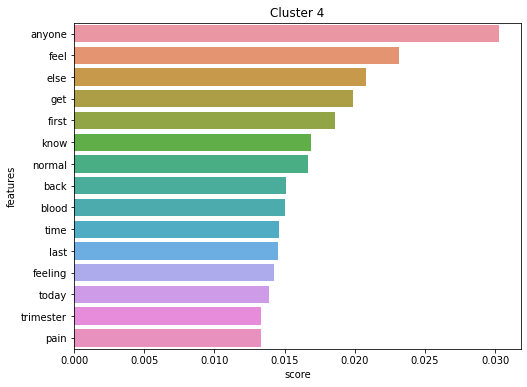

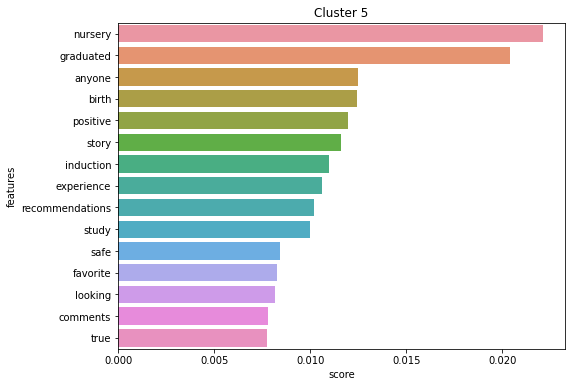

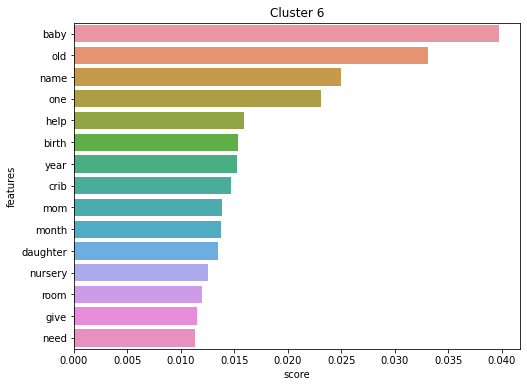

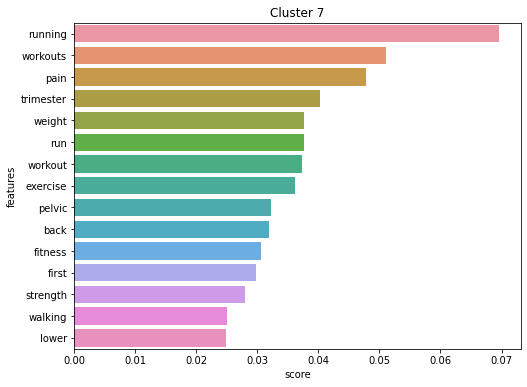

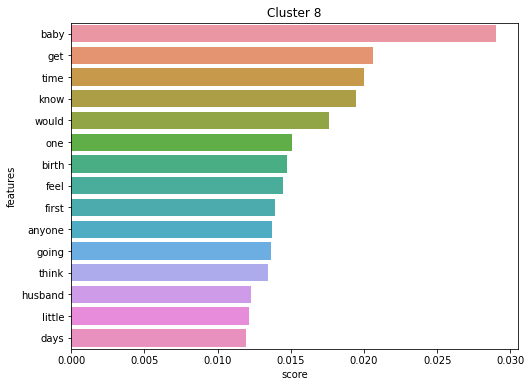

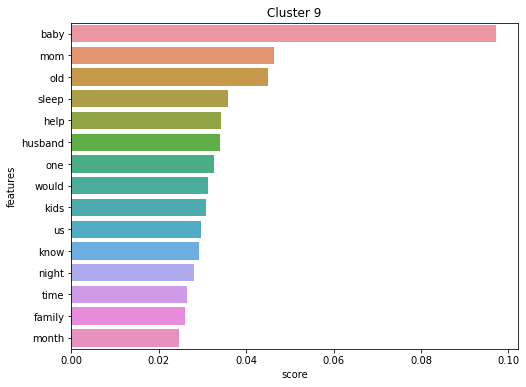

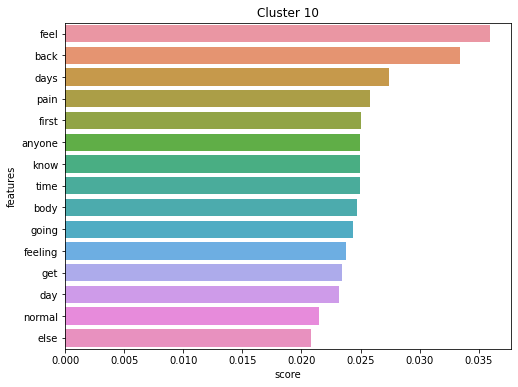

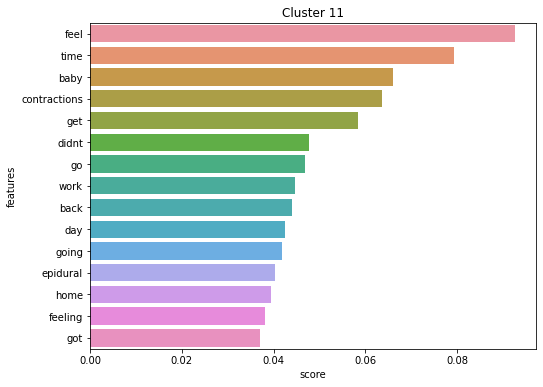

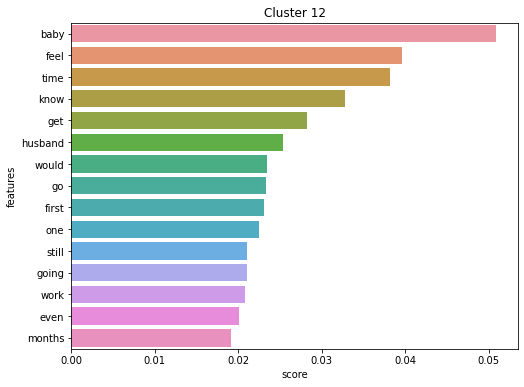

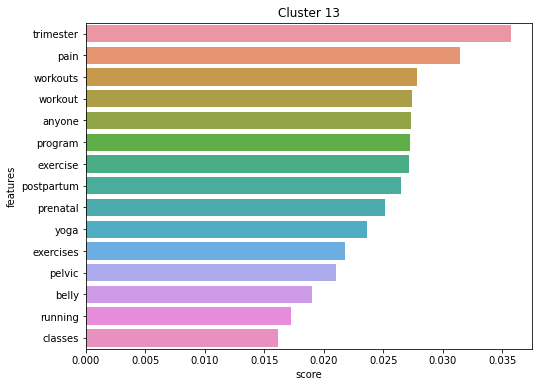

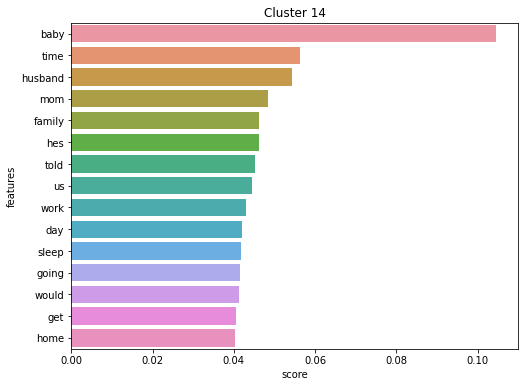

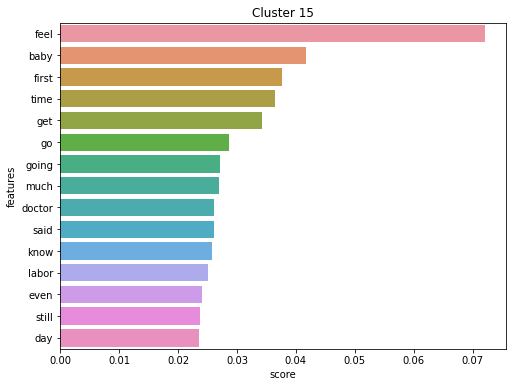

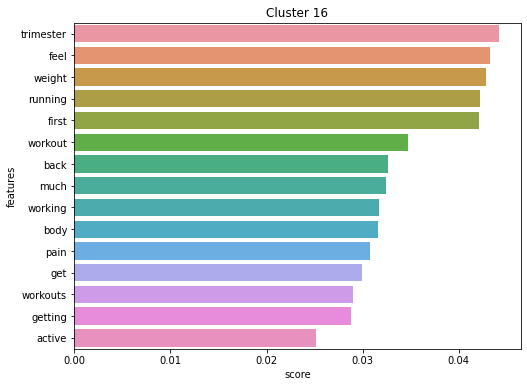

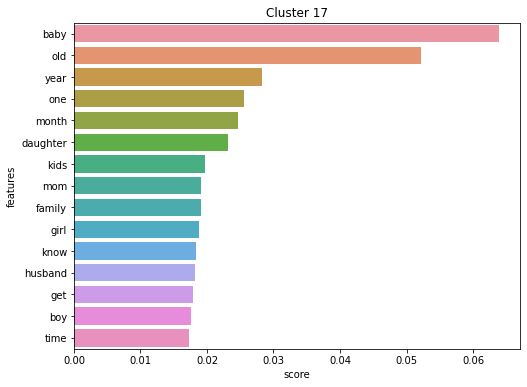

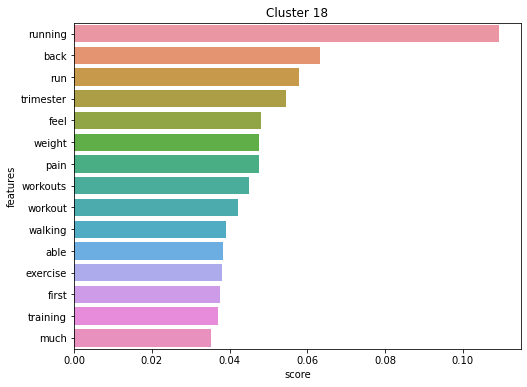

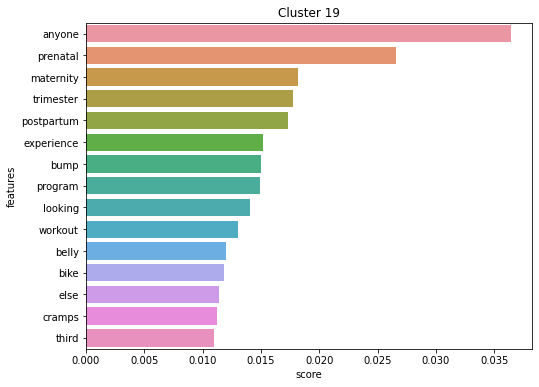

In [ ]:
import seaborn as sns
for i in range(20):
  plt.figure(figsize=(8,6))
  sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:15]).set_title('Cluster '+str(i))